# Forecasting GDP of Japan

In [3]:
# Importing Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from pmdarima import auto_arima

from warnings import filterwarnings
filterwarnings('ignore')

## Step 1: Import data and Initial observations

In [4]:
df = pd.read_csv(r"D:\9. Self Projects\4. Econometrics Project\Economy of a Country\Original Datasets\3. GDP Data.csv")
df.head()

,Year,Quarter_No,GDP
0,2000,1,479990.3
1,2000,2,482123.9
2,2000,3,482261.0
3,2000,4,486917.4
4,2001,1,490540.7


In [5]:
df.shape

(102, 3)

In [6]:
df.isnull().sum()

Year          0
Quarter_No    0
GDP           0
dtype: int64

## Step 2: Data Pre-processing

In [7]:
# Converting to a proper Date column for Time Series Analysis
df['Date'] = pd.PeriodIndex(year=df['Year'], quarter=df['Quarter_No']).to_timestamp()

#s To sorts DataFrame by its index
df = df.sort_index()

In [8]:
# Dropping the Extra year columns now
df = df.drop(['Year', 'Quarter_No'], axis=1)

In [9]:
# ASettiing the date column as index
df = df.set_index('Date') 

## Step 3: Visualization

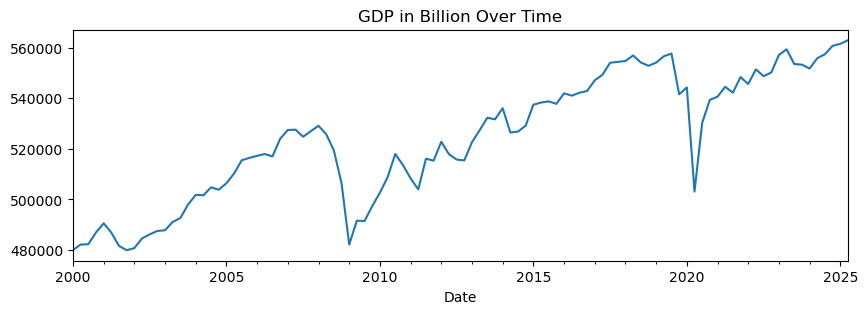

In [10]:
# Visualize the Time Series
# As date column is index I did not need to give date column explicitely

plt.figure(figsize=(10, 3)) 
df['GDP'].plot(title='GDP in Billion Over Time') # Only thhis can plot the graph

plt.show()

## Step 4: Checking Stationarity

In [11]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(df['GDP'])


ADF Statistic: -1.5877553853568884
p-value: 0.48974142788993685


In [12]:
# Differencing to make the data stationary
df['GDP_diff'] = df['GDP'].diff()

adf_test(df['GDP_diff'])

ADF Statistic: -11.543274516451635
p-value: 3.5913835051630485e-21


## Step 5: Plotting ACF & PACF

Figure(640x480)
Figure(640x480)


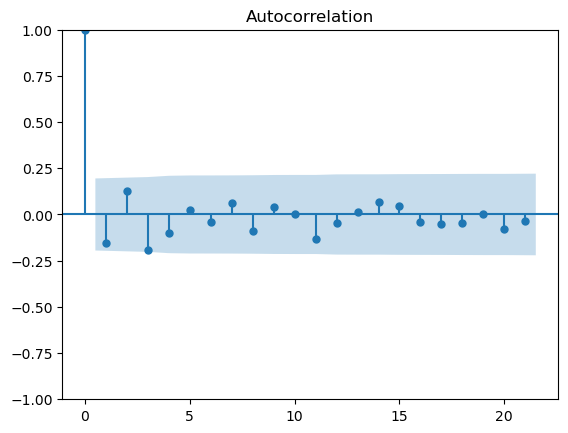

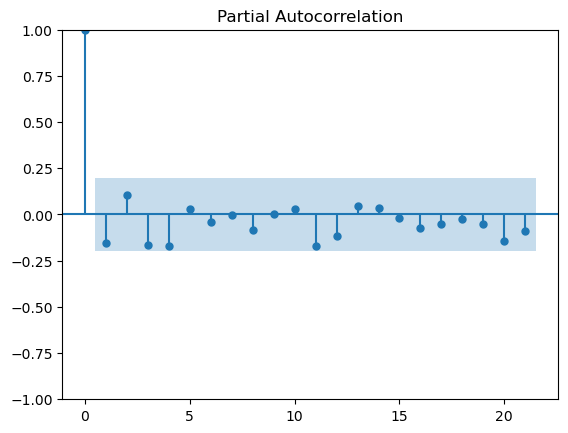

In [13]:
# To plot ACF
print(plot_acf(df['GDP_diff'].dropna()))

# To plot PACF
print(plot_pacf(df['GDP_diff'].dropna()))

## Step 6: Ploting the model

#### 1. Train Test the data

In [22]:
# Train Test Split data, (here 80% tarin and  20% test)
train_size = int(len(df) * 0.8)
train = df['GDP'][:train_size]
test = df['GDP'][train_size:]


#### 2. Hyperparameter tuning

In [23]:
# Using Auto Arima to know the best model
stepwise_fit = auto_arima(
    train,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print("Best model:", stepwise_fit.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1611.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1604.128, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1606.017, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1606.055, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1603.932, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1608.018, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 seconds
Best model: (0, 1, 0)


#### 3. Model Building

In [24]:
# Plotting ARIMA Model
p, d, q = stepwise_fit.order

model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   81
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -800.966
Date:                Fri, 14 Nov 2025   AIC                           1603.932
Time:                        17:03:28   BIC                           1606.314
Sample:                    01-01-2000   HQIC                          1604.887
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.874e+07   2.47e+06     11.654      0.000    2.39e+07    3.36e+07
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):               155.00
Prob(Q):                              0.27   Pr

In [25]:
# Forecast the test period
forecast = result.forecast(steps=len(test))


#### 4. Comparing Forecast vs Actual

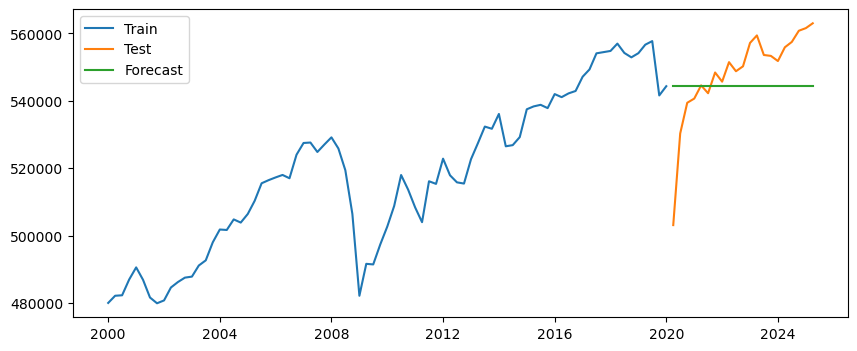

In [27]:
# Comparing forecast vs actual 

plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()


#### 5. Model Accuracy

In [28]:
# Checking model accuracy

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 10465.042857142864
RMSE: 13626.76373641575
MAPE: 1.9253820133654458


#### 6. Fitting to final model

In [29]:
# Fit ARIMA again on the full GDP series
model_final = ARIMA(df['GDP'], order=(p, d, q))
result_final = model_final.fit()


#### 7. Forecasting GDP

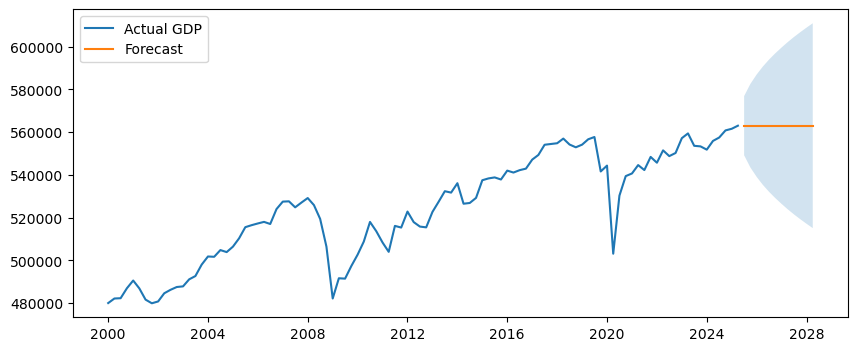

In [31]:
# Ploting the future GDP 
forecast_final = result_final.get_forecast(steps=12)      # 12 is for future months
pred = forecast_final.predicted_mean
ci = forecast_final.conf_int()

plt.figure(figsize=(10,4))
plt.plot(df['GDP'], label='Actual GDP')
plt.plot(pred, label='Forecast')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.show()


In [37]:
# Forecasting numerical values
forecast_table = pd.concat([pred, ci], axis=1) # pred gave Forecasted values and ci gave lower and upper values

# Rename columns
forecast_table.columns = ['Forecast_GDP', 'Lower_CI', 'Upper_CI']

# Display table
print(forecast_table.round(3))


            Forecast_GDP    Lower_CI    Upper_CI
2025-07-01      562987.8  549152.861  576822.739
2025-10-01      562987.8  543422.242  582553.358
2026-01-01      562987.8  539024.984  586950.616
2026-04-01      562987.8  535317.923  590657.677
2026-07-01      562987.8  532051.937  593923.663
2026-10-01      562987.8  529099.260  596876.340
2027-01-01      562987.8  526383.993  599591.607
2027-04-01      562987.8  523856.685  602118.915
2027-07-01      562987.8  521482.984  604492.616
2027-10-01      562987.8  519237.883  606737.717
2028-01-01      562987.8  517102.500  608873.100
2028-04-01      562987.8  515062.167  610913.433
